Imports

In [ ]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span
import en_core_web_sm
nlp = en_core_web_sm.load()

import string
import re

import wikipedia

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import gensim.downloader as api
from gensim.models.word2vec import Word2Vec

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

Load word vectors and stopwords

In [2]:
word_vectors = api.load("glove-wiki-gigaword-100")
stop_words = stopwords.words('english')

KG (graph specific) functionality

In [3]:
def create_KG(file):
    df = pd.read_csv(file, sep="\t", header=None)
    df_1hop = df[[0, 1, 2]].copy().rename(columns={0:"Subject", 1:"Predicate", 2:"Object"})
    df_2hop = df[[0, 3, 4]].copy().dropna().rename(columns={2:"Subject", 3:"Predicate", 4:"Object"})
    df_SPO = pd.concat([df_1hop, df_2hop])

    KG = nx.from_pandas_edgelist(df_SPO, source="Subject", target="Object", edge_attr="Predicate",create_using=nx.MultiDiGraph())
    return KG

def draw_KG(KG, size):
    plt.figure(figsize=(size,size))
    pos = nx.spring_layout(KG)
    nx.draw(KG,edge_attr=True, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    plt.show()

Other functionality

In [13]:
def get_wiki_title(entity):
    wiki_title = wikipedia.search(entity.text, results=1)[0]
    return wiki_title

def get_relation(doc):
    # Matcher class object 
    matcher = Matcher(nlp.vocab)
    
    #define the pattern 
    relation_deps = ["adj", "attr", "agent", "amod", "compound", "dobj", "nsubj", "acomp"]
    
    #define the pattern 
    pattern1 = [
            {'DEP': 'ROOT', 'OP':'?'},
            {'POS':'DET','OP':"?"},
            {'DEP': {'IN' :relation_deps}, 'OP': "*"},
            {'DEP':'prep', 'OP':"?"},
            {'POS': "NOUN", 'OP': "?"},
            {'DEP':'prep', 'OP':"?"}]
    
    matcher.add("relation_extraction", None, pattern1)
    
    pattern2 = [
            {'DEP': 'ROOT', 'OP':'?'},
            {'DEP': {'IN' :relation_deps}, 'OP': "*"},
            {'DEP':'prep', 'OP':"?"}]
    
    matcher.add("relation_extraction2", None, pattern2)
        
    matches = matcher(doc)
    k = len(matches) - 1
    max_spanlen = 0
    no = 0
    for elem in matches:
        match = doc[elem[1]:elem[2]]
        m = str(match.text)
        for ent in doc.ents:
            if (m in str(ent)) or (str(ent) in m):
                no = 1
        if(no == 1):
            no = 0
            continue
        spanlen = elem[2] - elem[1]
        if spanlen > max_spanlen:
            span = doc[elem[1]:elem[2]] 
            max_spanlen = spanlen
    
    return(span.text)

def get_entity_relation(query):
    sentence = query
    doc = nlp(sentence)
    print([(tok,tok.dep_, tok.pos_) for tok in doc])
    if(len(doc.ents) > 0):
        entity = doc.ents[0]
    else:
        doc2 = nlp("The Lord of the rings is a good movie.")
        LABEL = doc2.vocab.strings[u'WORK_OF_ART']
        entity = Span(doc2, 0, 5, label=LABEL)
        
    displacy.render(doc, jupyter=True, style='ent')
    displacy.render(doc, style='dep', jupyter = True, options = {'distance': 120})
    
    relation = get_relation(doc)
    print(f"Relation identified: {relation}")
    return entity, relation

def preprocess(text):
    lemmatizer = WordNetLemmatizer() 
    stopwords = stop_words
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    pp_text = text.lower().split()
    
    for ind, t in enumerate(pp_text):
        try:
            pp_text[ind] = lemmatizer.lemmatize(t)
            if ((t not in word_vectors.vocab) or  (t in stopwords)):
                pp_text.remove(t)
        except:
            continue
    return pp_text

def query_KG(entity, relation, KG):
    
    KGnodes = list(KG.nodes)
    entity_nodes = []
    wiki_entity = get_wiki_title(entity)
    relation_tokens = preprocess(relation)
    answers = []
    triple = []
    
    
    for entity_node in KGnodes:
        string0 = str(wiki_entity).lower()
        string1 = str(entity_node).lower()

        if((string0 in string1) or(string1 in string0)):
            entity_nodes.append(entity_node)
            try:
                level1 = [x for x in KG.edges(entity_node)]

                for tup in level1:
                    token = KG.get_edge_data(tup[0], tup[1])

                    for key in token.keys():
                        predicate = token[key]["Predicate"]
                        predicate_tokens = preprocess(predicate)
                        try:
                            sim = word_vectors.n_similarity(predicate_tokens, relation_tokens)
                            if sim > 0.5:
                                answers.append((tup[1], sim))
                                triple.append((tup[0], predicate, tup[1], sim))
                        except:
                            continue

            except Exception as e:
                print("Cannot answer question. Insufficient information.")
                print(str(e))
    
    answers = list(set(answers))
    triple = sorted(triple, key=lambda x: x[3], reverse=True)
    triple = list(set(triple))
    return sorted(answers, key = lambda x: x[1], reverse=True), triple

Main Program with outputs

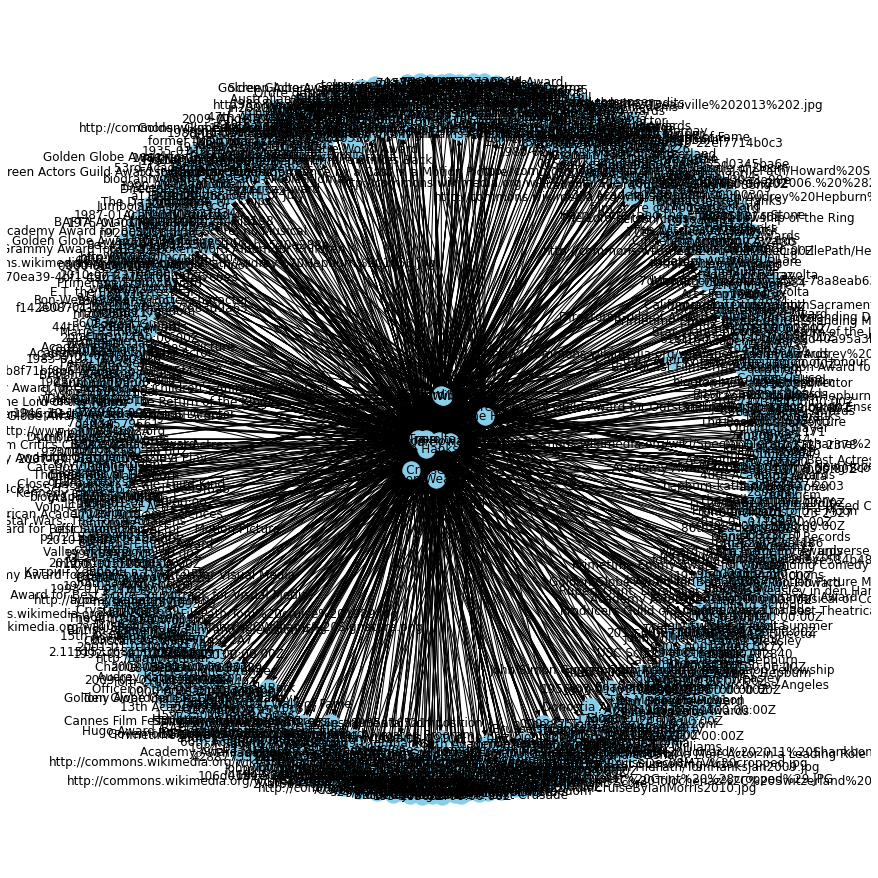

In [5]:
KG_file = "toy-kg.tsv"
KG = create_KG(KG_file)
draw_KG(KG, 12)

Execute Dev Queries

Query: What is the place of birth of Tom Hanks?
[(What, 'attr', 'PRON'), (is, 'ROOT', 'AUX'), (the, 'det', 'DET'), (place, 'nsubj', 'NOUN'), (of, 'prep', 'ADP'), (birth, 'pobj', 'NOUN'), (of, 'prep', 'ADP'), (Tom, 'compound', 'PROPN'), (Hanks, 'pobj', 'PROPN'), (?, 'punct', 'PUNCT')]


Relation identified: is the place of birth of
Answers ranked by score
[('Concord', 0.95917946), ('1956-07-09T00:00:00Z', 0.83095324), ('Thomas Jeffrey Hanks', 0.8251132), ('Tom', 0.79853684), ('1980-01-01T00:00:00Z', 0.7882023)]


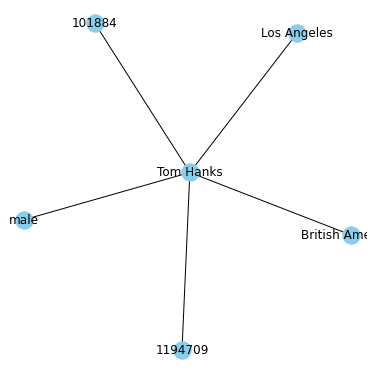

Query: What is the number of children of Tom Cruise?
[(What, 'attr', 'PRON'), (is, 'ROOT', 'AUX'), (the, 'det', 'DET'), (number, 'nsubj', 'NOUN'), (of, 'prep', 'ADP'), (children, 'pobj', 'NOUN'), (of, 'prep', 'ADP'), (Tom, 'compound', 'PROPN'), (Cruise, 'pobj', 'PROPN'), (?, 'punct', 'PUNCT')]


Relation identified: is the number of children of
Answers ranked by score
[('3', 0.95875335), ('Syracuse', 0.8024334), ('1107079', 0.7956314), ('Thomas', 0.76508343), ('Tomas', 0.76508343)]


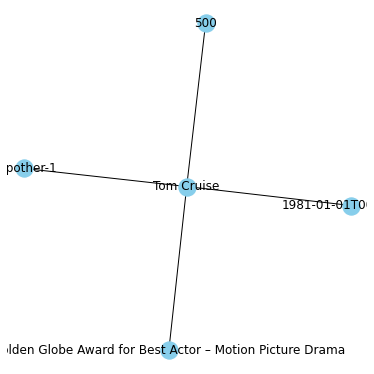

Query: Who are the siblings of Travolta?
[(Who, 'nsubj', 'PRON'), (are, 'ROOT', 'AUX'), (the, 'det', 'DET'), (siblings, 'attr', 'NOUN'), (of, 'prep', 'ADP'), (Travolta, 'pobj', 'PROPN'), (?, 'punct', 'PUNCT')]


Relation identified: are the siblings of
Answers ranked by score
[('Travolta', 0.7349834), ('Margaret Travolta', 0.69310015), ('Joey Travolta', 0.69310015), ('Ellen Travolta', 0.69310015), ('Englewood', 0.69097215)]


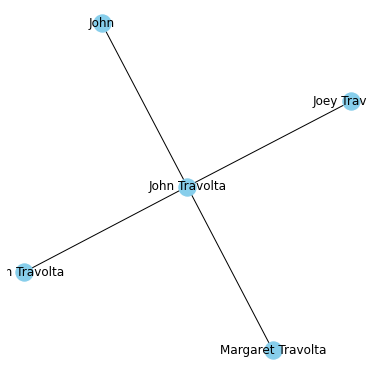

Query: What was the name of Hepburn at birth?
[(What, 'attr', 'PRON'), (was, 'ROOT', 'AUX'), (the, 'det', 'DET'), (name, 'nsubj', 'NOUN'), (of, 'prep', 'ADP'), (Hepburn, 'pobj', 'PROPN'), (at, 'prep', 'ADP'), (birth, 'pobj', 'NOUN'), (?, 'punct', 'PUNCT')]


Relation identified: was the name of
Answers ranked by score
[('Audrey', 0.702466), ('55528', 0.67345345), ('Audrey Hepburn', 0.63767886), ('74312022', 0.63227344), ('Audrey Kathleen Ruston', 0.6296053)]


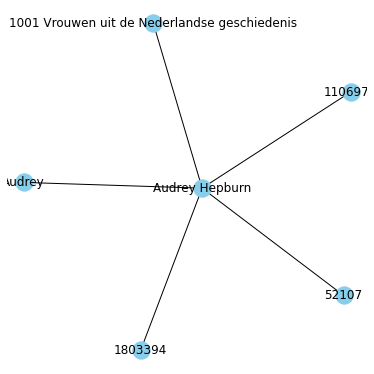

Query: Who was the father of Katharine Hepburn?
[(Who, 'attr', 'PRON'), (was, 'ROOT', 'AUX'), (the, 'det', 'DET'), (father, 'attr', 'NOUN'), (of, 'prep', 'ADP'), (Katharine, 'compound', 'PROPN'), (Hepburn, 'pobj', 'PROPN'), (?, 'punct', 'PUNCT')]


Relation identified: was the father of
Answers ranked by score
[('Thomas Norval Hepburn', 0.7492995), ('Hepburn', 0.6274987), ('Katharine Martha Houghton Hepburn', 0.59467506), ('Katharine', 0.5582788), ('Old Saybrook', 0.52122504)]


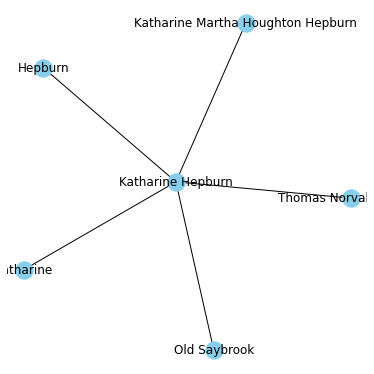

Query: What is the date of birth of Ron Howard?
[(What, 'attr', 'PRON'), (is, 'ROOT', 'AUX'), (the, 'det', 'DET'), (date, 'nsubj', 'NOUN'), (of, 'prep', 'ADP'), (birth, 'pobj', 'NOUN'), (of, 'prep', 'ADP'), (Ron, 'compound', 'PROPN'), (Howard, 'pobj', 'PROPN'), (?, 'punct', 'PUNCT')]


Relation identified: is the date of birth of
Answers ranked by score
[('1954-03-01T00:00:00Z', 0.94310653), ('Duncan', 0.91925615), ('Ronald William Howard', 0.87035197), ('Ron', 0.7967645), ('William', 0.7967645)]


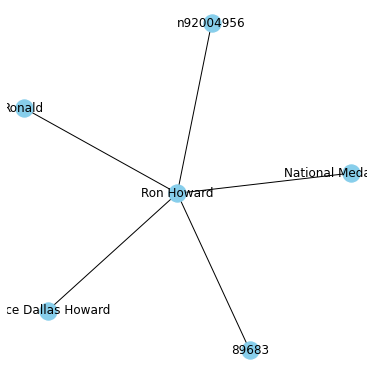

Query: What is the hair color of Ron Weasley?
[(What, 'attr', 'PRON'), (is, 'ROOT', 'AUX'), (the, 'det', 'DET'), (hair, 'compound', 'NOUN'), (color, 'nsubj', 'NOUN'), (of, 'prep', 'ADP'), (Ron, 'compound', 'PROPN'), (Weasley, 'pobj', 'PROPN'), (?, 'punct', 'PUNCT')]


Relation identified: is the hair color of
Answers ranked by score
[('orange hair', 0.93066454), ('red hair', 0.93066454), ('http://commons.wikimedia.org/wiki/Special:FilePath/Rupert%20Grint%20%28cropped%29.JPG', 0.69698477), ('Ronald', 0.6675983), ('Harry Potter', 0.6648793)]


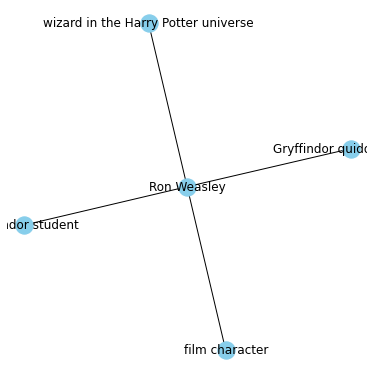

Query: Who did the soundtrack for Lord of the Rings?
[(Who, 'nsubj', 'PRON'), (did, 'ROOT', 'AUX'), (the, 'det', 'DET'), (soundtrack, 'dobj', 'NOUN'), (for, 'prep', 'ADP'), (Lord, 'pobj', 'PROPN'), (of, 'prep', 'ADP'), (the, 'det', 'DET'), (Rings, 'pobj', 'NOUN'), (?, 'punct', 'PUNCT')]


D:\Stuff\anaconda3\lib\site-packages\spacy\displacy\__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


Relation identified: did the soundtrack for
Sorry. Could not answer your question. I'll try to improve next time!
Query: Who composed the score for Harry Potter?
[(Who, 'nsubj', 'PRON'), (composed, 'ROOT', 'VERB'), (the, 'det', 'DET'), (score, 'dobj', 'NOUN'), (for, 'prep', 'ADP'), (Harry, 'compound', 'PROPN'), (Potter, 'pobj', 'PROPN'), (?, 'punct', 'PUNCT')]


Relation identified: composed the score for
Sorry. Could not answer your question. I'll try to improve next time!
Query: Who was Robin Williams married to?
[(Who, 'attr', 'PRON'), (was, 'ROOT', 'AUX'), (Robin, 'compound', 'PROPN'), (Williams, 'attr', 'PROPN'), (married, 'acomp', 'VERB'), (to, 'prep', 'ADP'), (?, 'punct', 'PUNCT')]


Relation identified: Williams married to
Answers ranked by score
[('Joseph Williams', 0.5989401), ('Williams', 0.5928354), ('John Towner Williams', 0.56146955), ('Long Island', 0.55224365), ('John_Williams', 0.51659477)]


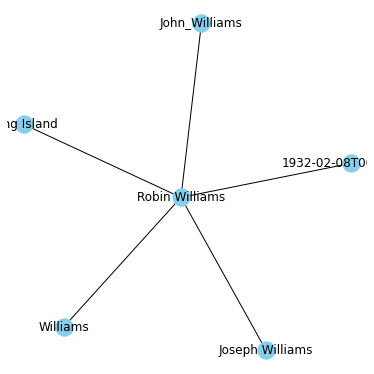

In [15]:
Queries = ["What is the place of birth of Tom Hanks?",
           "What is the number of children of Tom Cruise?",
           "Who are the siblings of Travolta?",
           "What was the name of Hepburn at birth?",
           "Who was the father of Katharine Hepburn?",
           "What is the date of birth of Ron Howard?",
           "What is the hair color of Ron Weasley?",
           "Who did the soundtrack for Lord of the Rings?",
           "Who composed the score for Harry Potter?",
           "Who was Robin Williams married to?"]

for query in Queries:
    print(f"Query: {query}")
    entity, relation = get_entity_relation(query)
    answers, triples = query_KG(entity, relation, KG)
    if(len(answers) > 0):
        print("Answers ranked by score")
        if(len(answers) < 5):
            print(answers)
        else:
            print(answers[0:5])
            triples = triples[0:5]

        G=nx.Graph()
        for triple in triples:
            G.add_edge(triple[0], triple[2])
        draw_KG(G, 5)
    else:
        print("Sorry. Could not answer your question. I'll try to improve next time!")
    print("==========================================================================================================")

Execute Test Queries

Query: What is the birth place of Tom Hanks?
[(What, 'attr', 'PRON'), (is, 'ROOT', 'AUX'), (the, 'det', 'DET'), (birth, 'compound', 'NOUN'), (place, 'nsubj', 'NOUN'), (of, 'prep', 'ADP'), (Tom, 'compound', 'PROPN'), (Hanks, 'pobj', 'PROPN'), (?, 'punct', 'PUNCT')]


Relation identified: is the birth place of
Answers ranked by score
[('Concord', 0.95917946), ('1956-07-09T00:00:00Z', 0.83095324), ('Thomas Jeffrey Hanks', 0.8251132), ('Tom', 0.79853684), ('1980-01-01T00:00:00Z', 0.7882023)]


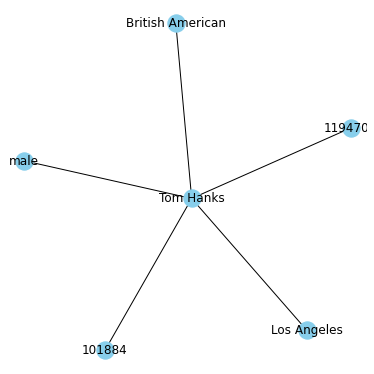

Query: Who is married to Tom Cruise?
[(Who, 'nsubj', 'PRON'), (is, 'ROOT', 'AUX'), (married, 'acomp', 'ADJ'), (to, 'prep', 'ADP'), (Tom, 'compound', 'PROPN'), (Cruise, 'pobj', 'PROPN'), (?, 'punct', 'PUNCT')]


Relation identified: is married to
Answers ranked by score
[('Connor Cruise', 0.6079941), ('Suri Cruise', 0.6079941), ('Isabella Jane Cruise', 0.6079941), ('Cruise', 0.58269024), ('Thomas Cruise Mapother IV', 0.5701309)]


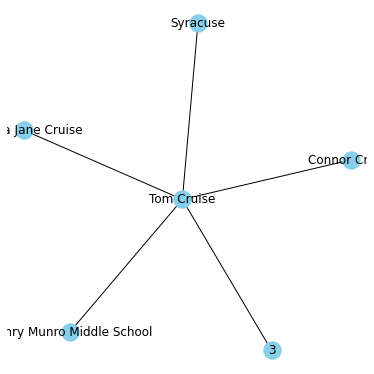

Query: What was the occupation of John Travolta?
[(What, 'attr', 'PRON'), (was, 'ROOT', 'AUX'), (the, 'det', 'DET'), (occupation, 'nsubj', 'NOUN'), (of, 'prep', 'ADP'), (John, 'compound', 'PROPN'), (Travolta, 'pobj', 'PROPN'), (?, 'punct', 'PUNCT')]


Relation identified: was the occupation of
Answers ranked by score
[('writer', 0.74086106), ('musician', 0.74086106), ('stage actor', 0.74086106), ('dancer', 0.74086106), ('film actor', 0.74086106)]


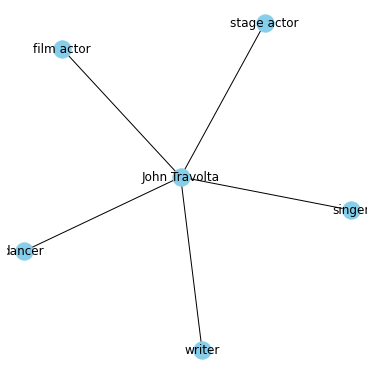

Query: How many children did Audrey Hepburn have?
[(How, 'advmod', 'ADV'), (many, 'amod', 'ADJ'), (children, 'dobj', 'NOUN'), (did, 'aux', 'AUX'), (Audrey, 'compound', 'PROPN'), (Hepburn, 'nsubj', 'PROPN'), (have, 'ROOT', 'AUX'), (?, 'punct', 'PUNCT')]


Relation identified: many children
Answers ranked by score
[('2', 0.9250382), ('Ixelles', 0.7607747), ('Tolochenaz', 0.7566571), ('1106975', 0.7375747), ('human', 0.72238564)]


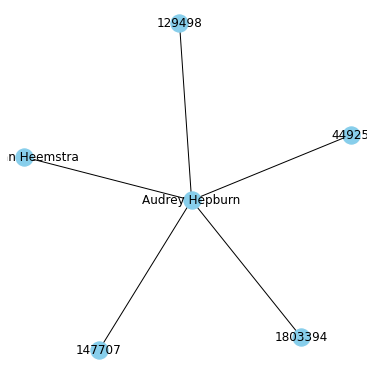

Query: Where was Katharine Hepburn born?
[(Where, 'advmod', 'ADV'), (was, 'auxpass', 'AUX'), (Katharine, 'compound', 'PROPN'), (Hepburn, 'nsubjpass', 'PROPN'), (born, 'ROOT', 'VERB'), (?, 'punct', 'PUNCT')]


Relation identified: born
Answers ranked by score
[('Thomas Norval Hepburn', 0.6616313), ('Katharine Martha Houghton Hepburn', 0.6198099), ('Bryn Mawr College', 0.57549834), ('Hepburn', 0.5667377), ('Katharine Hepburn', 0.5405664)]


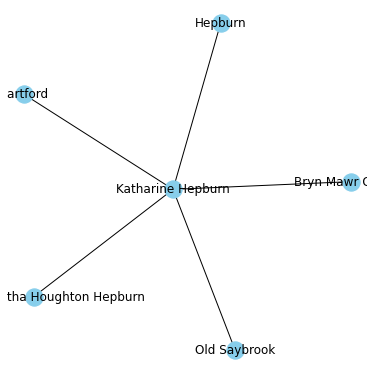

Query: What is the hair color of Ron Howard?
[(What, 'attr', 'PRON'), (is, 'ROOT', 'AUX'), (the, 'det', 'DET'), (hair, 'compound', 'NOUN'), (color, 'nsubj', 'NOUN'), (of, 'prep', 'ADP'), (Ron, 'compound', 'PROPN'), (Howard, 'pobj', 'PROPN'), (?, 'punct', 'PUNCT')]


Relation identified: is the hair color of
Answers ranked by score
[('red hair', 0.93066454), ('http://commons.wikimedia.org/wiki/Special:FilePath/Ron%20Howard%202011%20Shankbone%203.JPG', 0.69698477), ('Ron', 0.6675983), ('William', 0.6675983), ('Ronald', 0.6675983)]


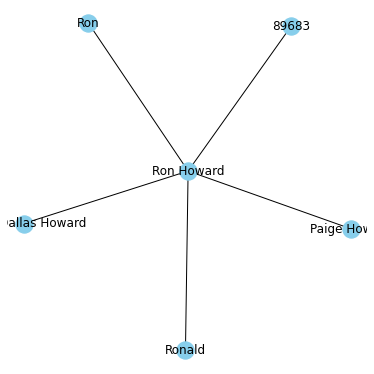

Query: Who performed as Ron Weasley in the movies?
[(Who, 'nsubj', 'PRON'), (performed, 'ROOT', 'VERB'), (as, 'prep', 'SCONJ'), (Ron, 'compound', 'PROPN'), (Weasley, 'pobj', 'PROPN'), (in, 'prep', 'ADP'), (the, 'det', 'DET'), (movies, 'pobj', 'NOUN'), (?, 'punct', 'PUNCT')]


Relation identified: performed as
Answers ranked by score
[('Harry Potter', 0.76251024), ("Harry Potter and the Philosopher's Stone", 0.76251024), ('Harry Potter and the Cursed Child', 0.76251024), ('Harry Potter and the Goblet of Fire', 0.76251024), ('Weasley family', 0.75925887)]


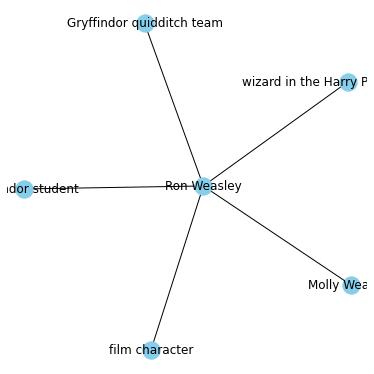

Query: Where was Howard Shore educated at?
[(Where, 'advmod', 'ADV'), (was, 'auxpass', 'AUX'), (Howard, 'compound', 'PROPN'), (Shore, 'nsubj', 'PROPN'), (educated, 'ROOT', 'VERB'), (at, 'prep', 'ADP'), (?, 'punct', 'PUNCT')]


Relation identified: educated at
Answers ranked by score
[('Berklee College of Music', 0.99999994)]


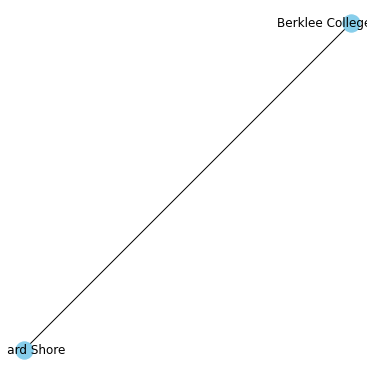

Query: Who was the son of John Williams?
[(Who, 'nsubj', 'PRON'), (was, 'ROOT', 'AUX'), (the, 'det', 'DET'), (son, 'attr', 'NOUN'), (of, 'prep', 'ADP'), (John, 'compound', 'PROPN'), (Williams, 'pobj', 'PROPN'), (?, 'punct', 'PUNCT')]


Relation identified: was the son of
Answers ranked by score
[('Williams', 0.55814993), ('John Towner Williams', 0.522707), ('John', 0.5018293)]


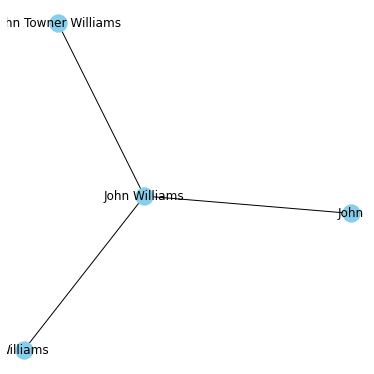

Query: How did Robin Williams die?
[(How, 'advmod', 'ADV'), (did, 'aux', 'AUX'), (Robin, 'compound', 'PROPN'), (Williams, 'nsubj', 'PROPN'), (die, 'ROOT', 'VERB'), (?, 'punct', 'PUNCT')]


Relation identified: die
Sorry. Could not answer your question. I'll try to improve next time!


In [20]:
Queries = ["What is the birth place of Tom Hanks?", 
           "Who is married to Tom Cruise?",
           "What was the occupation of John Travolta?",
           "How many children did Audrey Hepburn have?",
           "Where was Katharine Hepburn born?",
           "What is the hair color of Ron Howard?",
           "Who performed as Ron Weasley in the movies?",
           "Where was Howard Shore educated at?",
           "Who was the son of John Williams?",
           "How did Robin Williams die?"]

for query in Queries:
    print(f"Query: {query}")
    entity, relation = get_entity_relation(query)
    answers, triples = query_KG(entity, relation, KG)
    if(len(answers) > 0):
        print("Answers ranked by score")
        if(len(answers) < 5):
            print(answers)
        else:
            print(answers[0:5])
            triples = triples[0:5]

        G=nx.Graph()
        for triple in triples:
            G.add_edge(triple[0], triple[2])
        draw_KG(G, 5)
    else:
        print("Sorry. Could not answer your question. I'll try to improve next time!")
    print("==========================================================================================================")

---